<a href="https://colab.research.google.com/github/Alekhya-koda/Fake-Job-Prediction-/blob/main/ML_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import csv
import seaborn as sb
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


# **Data Describing**

In [ ]:
#Loading the dataset
data_file = '/content/gdrive/MyDrive/fake_job_postings.csv'
jobpost = pd.read_csv(data_file)

In [ ]:
# Exploring the dataset
jobpost.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# Looking at the number of missing values from each feature
jobpost.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Checking the Correlation of the features
jobpost.corr()

<ipython-input-6-4b4b0d7825c1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  jobpost.corr()


,job_id,telecommuting,has_company_logo,has_questions,fraudulent
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000


In [ ]:
# Removing the nominal data
jobpost.drop(['job_id', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions'],axis=1,inplace = True)
print(jobpost.columns)

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent'],
      dtype='object')


In [ ]:
# Handling the missing values
print("Removed Na values from all the columns")
jobpost.fillna(' ', inplace=True)
jobpost.isna().sum()

Removed Na values from all the columns


title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

# **Exploratory  Analysis**

In [ ]:
#Creating a Dataframe for Fraudulent Jobs
fraud_job=jobpost[jobpost["fraudulent"]==1]

<ipython-input-10-4c134bf4fe4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_job["country"]=country.str.slice(stop=2)


Text(0.5, 0, 'Countries')

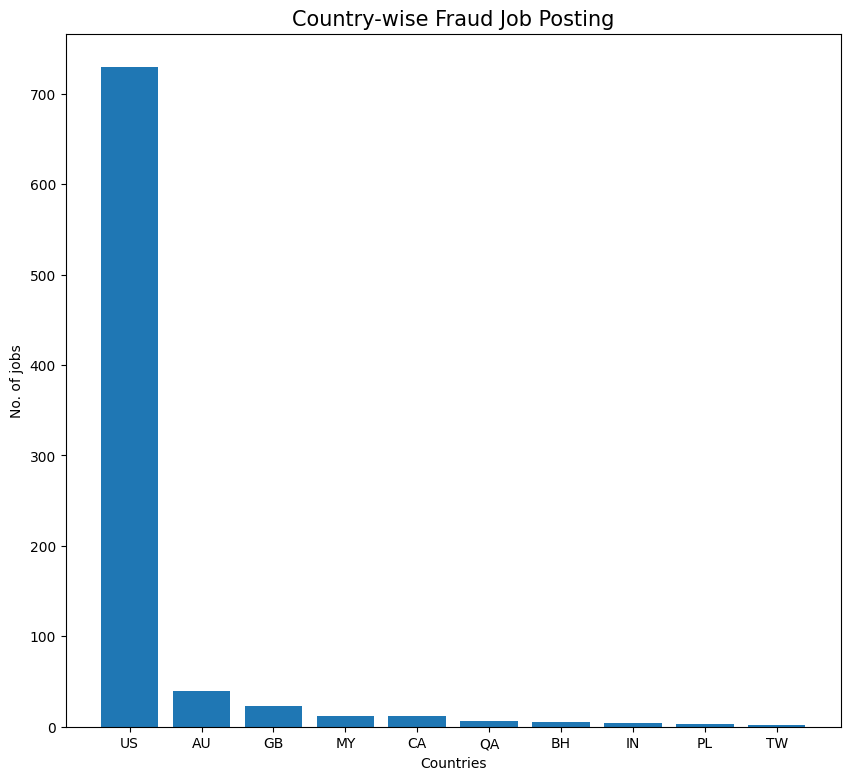

In [ ]:
#Adding new column for Country
country=jobpost["location"]
fraud_job["country"]=country.str.slice(stop=2)
fraud_job["country"].astype('category')

# Taking the most frequent countries mentioned in the dataset
fraud_job['country'].value_counts()[:11]


# creating a dictionary with the most frequent countires in the dataset
country = dict(fraud_job.country.value_counts()[:11])
del country[' '] #deleting country with space values
plt.figure(figsize=(10,9))
plt.title('Country-wise Fraud Job Posting', size=15)
plt.bar(country.keys(), country.values()) #(xaxis,yaxis)
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

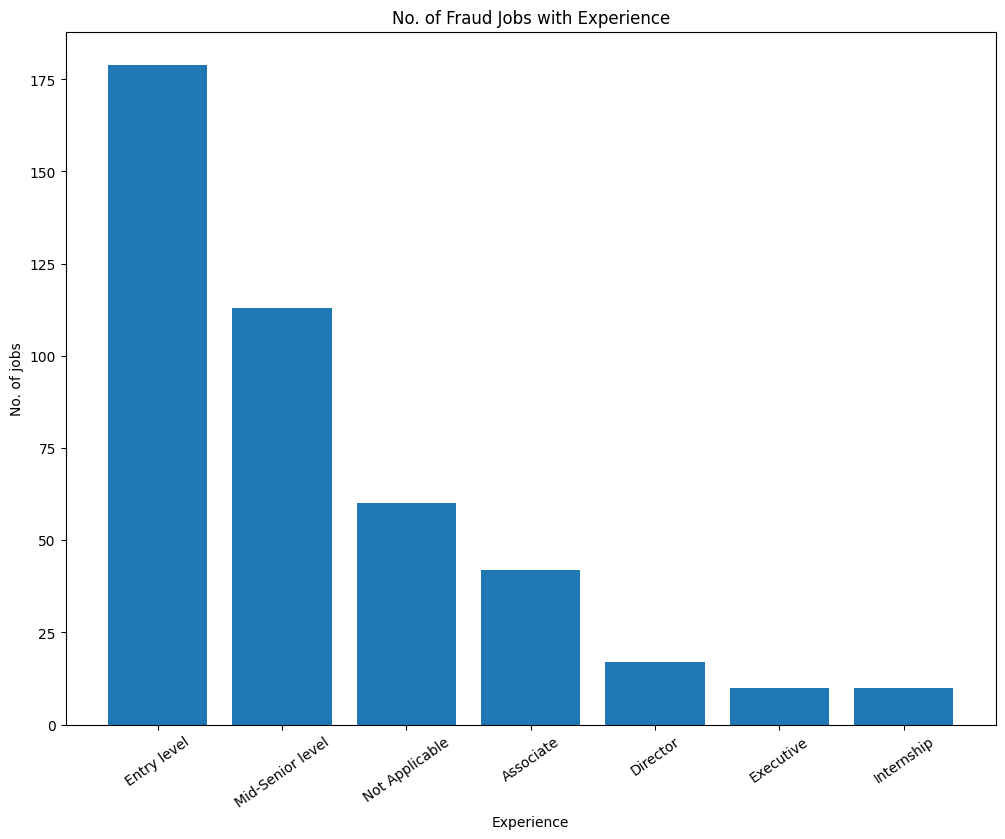

In [ ]:
# Creating a bar graph to visulaise the amount of fraud jobs based on experience
Experience = dict(fraud_job.required_experience.value_counts())
del Experience[' ']
plt.figure(figsize=(12,9))
plt.bar(Experience.keys(), Experience.values())
plt.title('No. of Fraud Jobs with Experience')
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

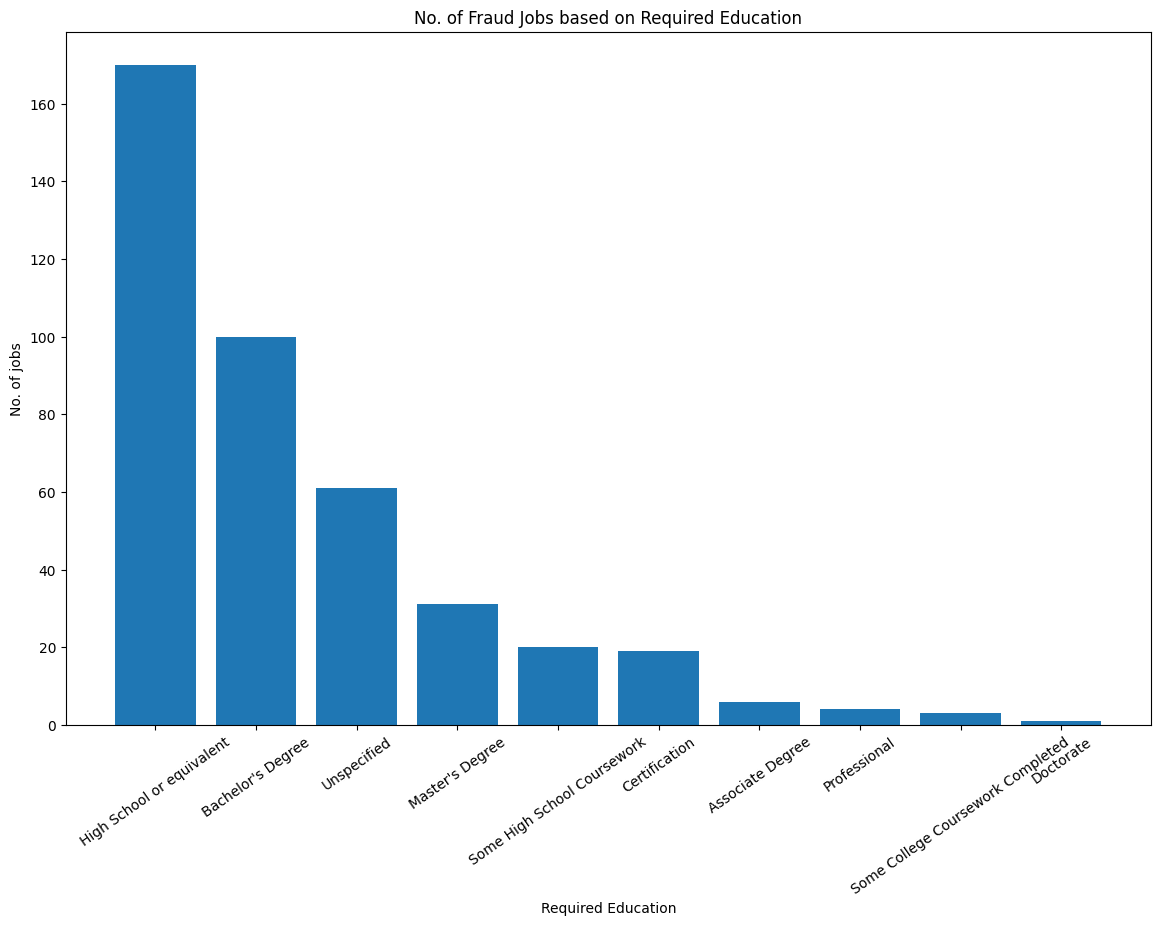

In [ ]:
# Creating a bar graph to visulaise the amount of fraud jobs based on Education Required
Edu = dict(fraud_job.required_education.value_counts())
del Edu[' ']
plt.figure(figsize=(14,9))
plt.bar(Edu.keys(), Edu.values())
plt.title('No. of Fraud Jobs based on Required Education')
plt.xlabel('Required Education', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


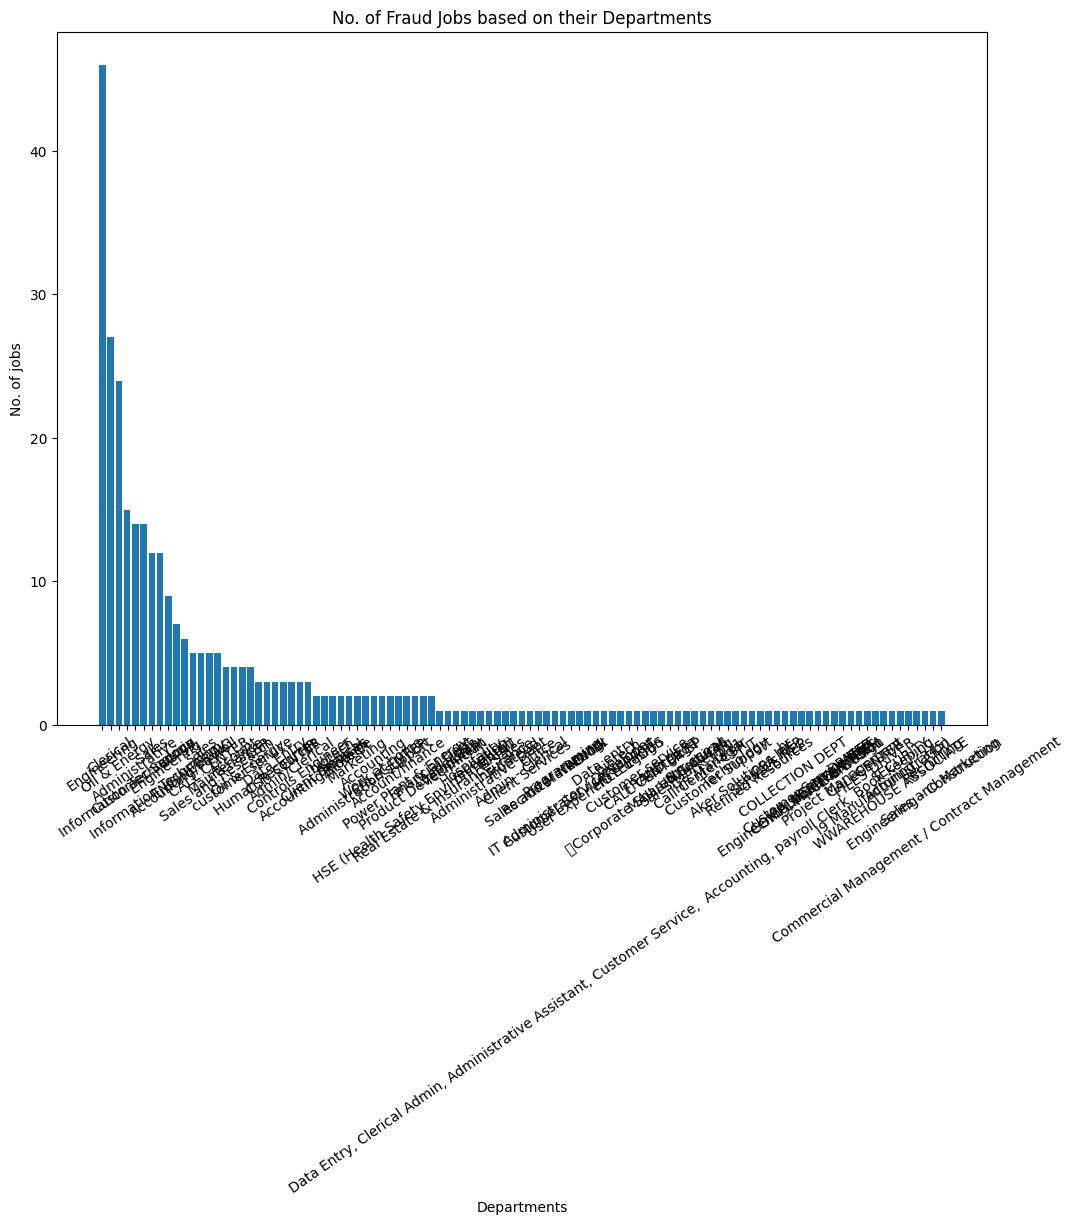

In [ ]:
# Taking the most frequent countries mentioned in the dataset
fraud_job['department'].value_counts()[:11]

# Creating a bar graph to visulaise the amount of fraud jobs based on Different Departments
Department = dict(fraud_job.department.value_counts())
del Department[' ']
plt.figure(figsize=(12,9))
plt.bar(Department.keys(), Department.values())
plt.title('No. of Fraud Jobs based on their Departments')
plt.xlabel('Departments', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

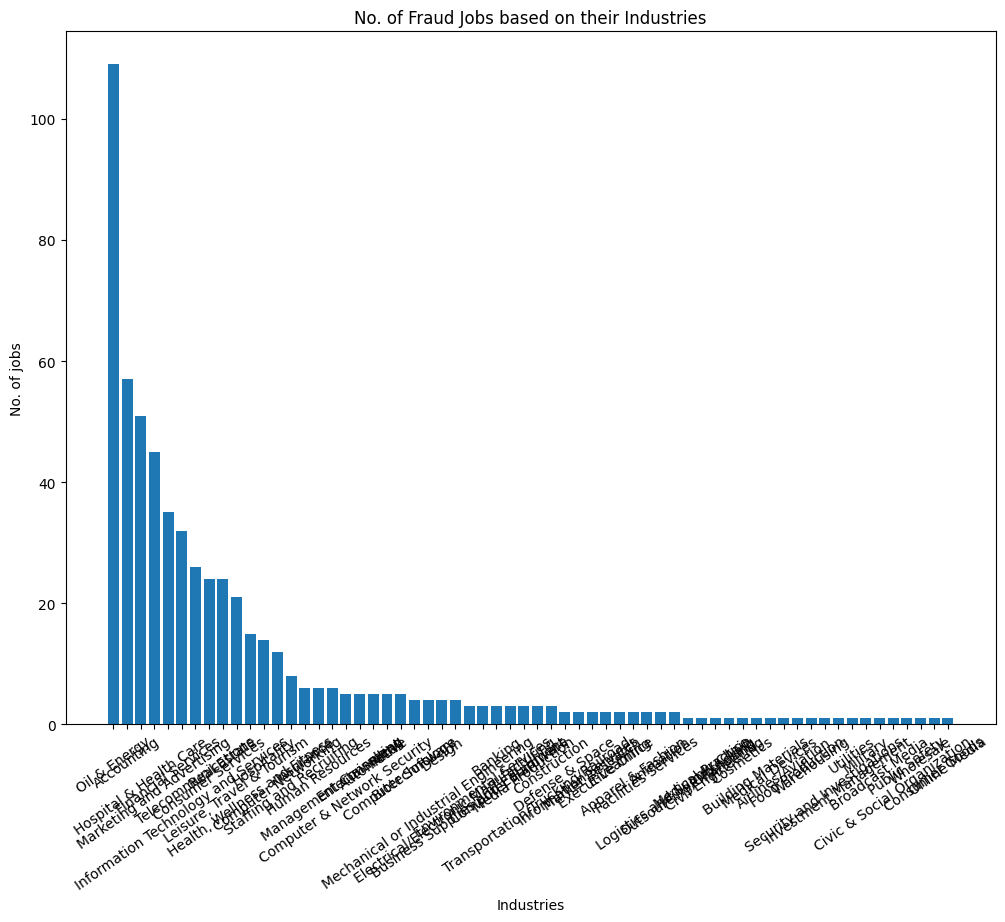

In [ ]:
# Taking the most frequent countries mentioned in the dataset
fraud_job['department'].value_counts()[:11]

# Creating a bar graph to visulaise the amount of fraud jobs based on Different Departments
Industry = dict(fraud_job.industry.value_counts())
del Industry[' ']
plt.figure(figsize=(12,9))
plt.bar(Industry.keys(), Industry.values())
plt.title('No. of Fraud Jobs based on their Industries')
plt.xlabel('Industries', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=35)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


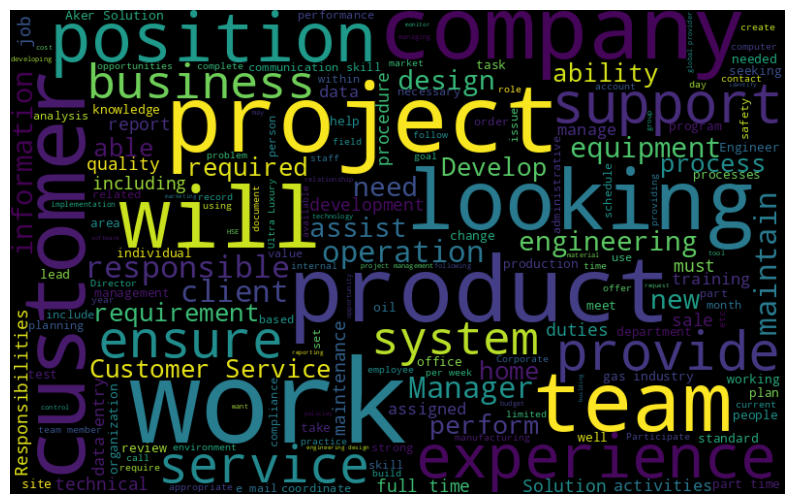

In [ ]:
#Plots the words that appear frequently in Fraud job postings
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('stopwords')

all_text=fraud_job.description
fraud_post = ''.join([text for text in jobpost["description"][jobpost['fraudulent'] == 1]])

wordcloud = WordCloud(width = 800, height = 500, random_state=21, max_font_size=120).generate(fraud_post)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

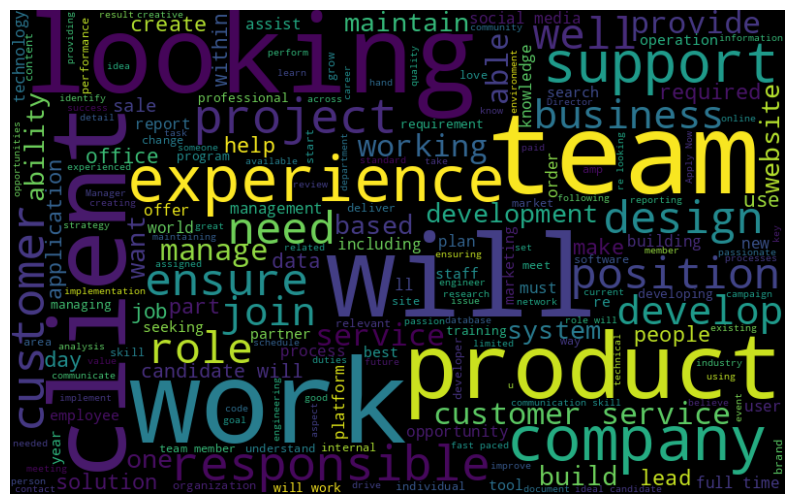

In [ ]:
#Plots the words that appear frequently in Real job postings
import matplotlib.pyplot as plt
from wordcloud import WordCloud

real_post = jobpost[jobpost.fraudulent==0].description

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Data Pre-Processing**

In [ ]:
print("Splitting data into X & y, fraudulent column as the target variable")
y = jobpost['fraudulent']
X = jobpost.drop('fraudulent', axis=1)
print("Number Of Records in X: ",len(X))
print("Number Of Records in y: ",len(y))

Splitting data into X & y, fraudulent column as the target variable
Number Of Records in X:  17880
Number Of Records in y:  17880


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text,stop_words):
    tokens = word_tokenize(text.lower())
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    words = [word for word in words if not word in stop_words]
    # Join the words back into a string
    cleaned_text = ' '.join(words)
    return cleaned_text


X['MergeText'] = X.apply(lambda row: ' '.join(row), axis=1)
X['Cleaned_Text'] = X['MergeText'].apply(lambda x: clean_text(x, stop_words))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print("Merged Text Example : ",X["MergeText"][0])
print("Cleaned Text Example : ",X["Cleaned_Text"][0])

Merged Text Example :  Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winni

In [ ]:
y=y.to_frame()
X_train, X_test, y_train, y_test = train_test_split(X["Cleaned_Text"], y['fraudulent'], test_size=0.2, random_state=42)

In [ ]:
vectorizer = CountVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

# **Training the Model**

In [ ]:
print("X_Train shape : ",X_train_vector.shape)
print("X_Test shape : ",X_test_vector.shape)
print("y_Test shape : ",y_train.shape)
print("y_Test shape : ",y_test.shape)

X_Train shape :  (14304, 123677)
X_Test shape :  (3576, 123677)
y_Test shape :  (14304,)
y_Test shape :  (3576,)


In [ ]:
classifier = LogisticRegression(class_weight='balanced', max_iter=1000)
classifier.fit(X_train_vector, y_train)

# Predictions on the testing set
predictions = classifier.predict(X_test_vector)

In [ ]:
# Calculating and printing the acuracy of Logistic Regression
accuracy = accuracy_score(y_test, predictions)
print("Accuracy of Logistic Regression:", accuracy)
print(" ")

# Generating classification report
report = classification_report(y_test, predictions)

# Printing the classification report for Logistic regression
print("Classification Report Of Logistic Rgeression:")
print(report)


Accuracy of Logistic Regression: 0.9846196868008948
 
Classification Report Of Logistic Rgeression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.85      0.85      0.85       181

    accuracy                           0.98      3576
   macro avg       0.92      0.92      0.92      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
# Training the dataset with Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train_vector, y_train)

DecisionTreeClassifier()

In [ ]:
# Predicting using Desicion Tree as a Classifier
dtc_predictions= clf.predict(X_test_vector)

# Calculating the accuracy for dtc
accuracy = accuracy_score(y_test, dtc_predictions)
print("Accuracy:", accuracy)
print(" ")

# Printing the classification report for dtc
print("Classification Report:")
print(classification_report(y_test, dtc_predictions,))

Accuracy: 0.9815436241610739
 
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3395
           1       0.87      0.75      0.80       181

    accuracy                           0.98      3576
   macro avg       0.93      0.87      0.90      3576
weighted avg       0.98      0.98      0.98      3576

